<font size=3>
Ensemble learning in machine learning combines multiple individual models to create a stronger, more accurate predictive model. By leveraging the diverse strengths of different models, ensemble learning aims to mitigate errors, enhance performance, and increase the overall robustness of predictions, leading to improved results across various tasks in machine learning and data analysis.</br>

[1] Ensemble Learning in Machine Learning: Stacking, Bagging and Boosting Mbali Kalirane https://www.analyticsvidhya.com/
</font>

<div>
    <img src="img/Figure_1.png" width="500"/>
</div>

<font size=3>
When to use Bagging vs Boosting vs Stacking? 
</font>

<div>
    <img src="img/Figure_2.jpg" width="500"/>
</div>

<font size=3>
[2] Bagging vs Boosting vs Stacking in Machine Learning Amy https://grabngoinfo.com 
</font>

In [1]:
%reset

# Imports

In [26]:
# imports

# ensambles
import xgboost
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

# meta models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt

# Load and preprocess data

In [3]:
# load data https://www.kaggle.com/competitions/titanic/data

data = pd.read_csv('data/train.csv', sep=',')

In [4]:
def preproces(data: pd.DataFrame):

    # preprocess Age
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    data[['Age']] = imputer.fit_transform(data[['Age']])

    # preprocess Embarked
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    data[['Embarked']] = imputer.fit_transform(data[['Embarked']])

    data=data.drop(labels=['Cabin', 'PassengerId', 'Name'], axis=1)

    # preprocess Tickets (LINE - value in one cell)
    new_tickets = []

    for i in data['Ticket']:
        ii = i.split()
        if ii == 'LINE':
            ii = '0'
        if len(ii) == 1:
            new_tickets.append(ii[0])
        elif len(ii) == 2:
            new_tickets.append(ii[1])
        elif len(ii) == 3:
            new_tickets.append(ii[2])

    data['Ticket'] = new_tickets

    new_emb = pd.get_dummies(data=data['Embarked'], prefix='emb', prefix_sep='_')
    new_sex = pd.get_dummies(data['Sex'], prefix='sex', prefix_sep='_')
    data.drop(labels=['Embarked', 'Sex', 'Ticket'], axis=1, inplace=True)
    data = pd.concat((data, new_emb, new_sex), axis=1)
    #data = pd.concat((data, new_sex), axis=1) # without embarked

    return data

## Preprocess and split train data to train and validation subsets

In [5]:
data = preproces(data)

y = data['Survived']
X = data.drop(labels=['Survived'], axis=1)

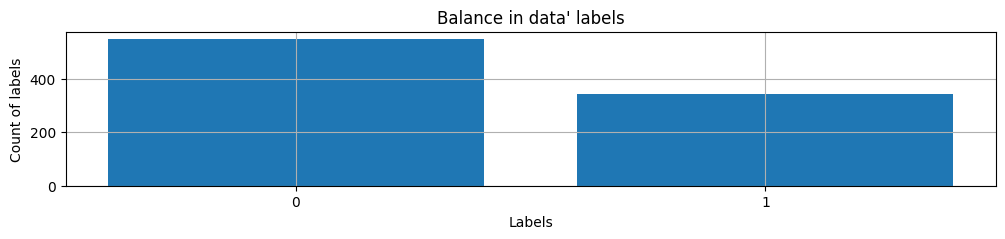

In [6]:
# check labels' balance

d = collections.Counter(y)

fig, ax = plt.subplots(figsize=(12, 2))
ax.bar(d.keys(), d.values())
ax.set_xticks(ticks=list(d.keys()), labels=d.keys())
ax.set_title('Balance in data\' labels')
plt.xlabel('Labels')
plt.ylabel('Count of labels')
plt.grid()
plt.show()

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  train_size=0.8, 
                                                  random_state=42)

In [8]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)

# Random Forest Classifier 

In [9]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             max_depth=None,
                             class_weight=None,
                             verbose=False,
                             n_jobs=-1)
rfc.fit(X_train_sc, y_train)
y_pred = rfc.predict(X_val_sc)

# Metrics on train data

y_pred_train = rfc.predict(X_train_sc)
accuracy = accuracy_score(y_train, y_pred_train)
precission, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='macro')

print(f"Random Forest Classifier (for train)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

y_pred_valid = rfc.predict(X_val_sc)
accuracy = accuracy_score(y_val, y_pred_valid)
precission, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_valid, average='macro')

print(f"\nRandom Forest Classifier (for validation)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

Random Forest Classifier (for train)
accuracy: 0.98
precission: 0.98
recall: 0.97
f1-score: 0.98
Random Forest Classifier (for validation)
accuracy: 0.80
precission: 0.79
recall: 0.79
f1-score: 0.79


In [10]:
# Random Forest Classifier with weighting

w0 = len(y_train) / (len(np.unique(y_train)) * len(y_train[y_train==0]))
w1 = len(y_train) / (len(np.unique(y_train)) * len(y_train[y_train==1]))

rfc = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             max_depth=None,
                             class_weight={0:w0, 1:w1},
                             verbose=False,
                             n_jobs=-1)

rfc.fit(X_train_sc, y_train)
y_pred_train = rfc.predict(X_train_sc)
y_pred_valid = rfc.predict(X_val_sc)

# Metrics on train data

accuracy = accuracy_score(y_train, y_pred_train)
precission, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='macro')

print(f"Random Forest Classifier (for train)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

accuracy = accuracy_score(y_val, y_pred_valid)
precission, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_valid, average='macro')

print(f"\nRandom Forest Classifier (for validation)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

Random Forest Classifier (for train)
accuracy: 0.98
precission: 0.98
recall: 0.98
f1-score: 0.98

Random Forest Classifier (for validation)
accuracy: 0.81
precission: 0.80
recall: 0.80
f1-score: 0.80


# Bagging (Random Forest Classifier)

<font size=3>
<p>&emsp; 1. From n-elements training set choose m-subsets. Each subset is taken with replacement. Some data points can be sampled more than once.<p>
<p>&emsp; 2. For each subset train weak learner independently. Learner are the same type. <p>
<p>&emsp; 3. Each model make a prediction.<p>
<p>&emsp; 4. Aggregation the predictions. Using max voting (for classification) or averaging (for regression) yeilds single prediction<p>
</font>

In [11]:
# for homogeneous estimators (hier rfc)
# for high variance results

bag = BaggingClassifier(estimator=rfc, n_estimators=100, max_samples=1.0,
                        max_features=1.0, bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=-1)

bag.fit(X_train_sc, y_train)
y_pred_train = bag.predict(X_train_sc)
y_pred_valid = bag.predict(X_val_sc)

accuracy = accuracy_score(y_train, y_pred_train)
precission, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='macro')

print(f"Bagging (Random Forest Classifier) (for train)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

accuracy = accuracy_score(y_val, y_pred_valid)
precission, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_valid, average='macro')

print(f"\nBagging (Random Forest Classifier) (for validation)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

Bagging (Random Forest Classifier) (for train)
accuracy: 0.94
precission: 0.95
recall: 0.93
f1-score: 0.94

Bagging (Random Forest Classifier) (for validation)
accuracy: 0.84
precission: 0.84
recall: 0.83
f1-score: 0.83


# Boosting (GradientBoostingClassifier)

<font size=3>
<p>&emsp; 1. From n-elements training set choose m-subsets. Each subset is taken with replacement. Some data points can be sampled more than once.<p>
<p>&emsp; 2. Using first subset train first weak learner. <p>
<p>&emsp; 3. Test using training data.<p>
<p>&emsp; 4. All False predicted Data Points from 1st subset are send to 2nd subset.<p>
<p>&emsp; 5. Using update 2nd subset train anather weak learner.<p>
<p>&emsp; 6. Loop using above procedure until reach last subset.<p>
</font>

In [12]:
gbc = GradientBoostingClassifier(n_estimators=200)

gbc.fit(X_train_sc, y_train)
y_pred_train = gbc.predict(X_train_sc)
y_pred_valid = gbc.predict(X_val_sc)

accuracy = accuracy_score(y_train, y_pred_train)
precission, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='macro')

print(f"Gradient Boosting Classifier (Random Forest Classifier) (for train)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

accuracy = accuracy_score(y_val, y_pred_valid)
precission, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_valid, average='macro')

print(f"\nGradient Boosting Classifier (Random Forest Classifier) (for validation)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

Gradient Boosting Classifier (Random Forest Classifier) (for train)
accuracy: 0.93
precission: 0.94
recall: 0.91
f1-score: 0.92

Gradient Boosting Classifier (Random Forest Classifier) (for validation)
accuracy: 0.82
precission: 0.81
recall: 0.80
f1-score: 0.81


# Boosting (AdaBoost)

In [13]:
ada = AdaBoostClassifier(estimator=rfc, n_estimators=200)

ada.fit(X_train_sc, y_train)
y_pred_train = ada.predict(X_train_sc)
y_pred_valid = ada.predict(X_val_sc)

accuracy = accuracy_score(y_train, y_pred_train)
precission, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='macro')

print(f"AdaBoost Classifier (Random Forest Classifier) (for train)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

accuracy = accuracy_score(y_val, y_pred_valid)
precission, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_valid, average='macro')

print(f"\nAdaBoost Classifier (Random Forest Classifier) (for validation)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

AdaBoost Classifier (Random Forest Classifier) (for train)
accuracy: 0.98
precission: 0.98
recall: 0.98
f1-score: 0.98

AdaBoost Classifier (Random Forest Classifier) (for validation)
accuracy: 0.82
precission: 0.81
recall: 0.81
f1-score: 0.81


# Boosintg (XGBoost)

In [14]:
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

xgb.fit(X_train_sc, y_train)
y_pred_train = xgb.predict(X_train_sc)
y_pred_valid = xgb.predict(X_val_sc)

accuracy = accuracy_score(y_train, y_pred_train)
precission, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='macro')

print(f"XGBoost Classifier (Random Forest Classifier) (for train)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

accuracy = accuracy_score(y_val, y_pred_valid)
precission, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_valid, average='macro')

print(f"\nXGBoost Classifier (Random Forest Classifier) (for validation)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")


XGBoost Classifier (Random Forest Classifier) (for train)
accuracy: 0.93
precission: 0.94
recall: 0.91
f1-score: 0.92

XGBoost Classifier (Random Forest Classifier) (for validation)
accuracy: 0.81
precission: 0.81
recall: 0.80
f1-score: 0.80


# Stacking (meta_model=LogisticRegression)

<font size=3>
<p>&emsp; 1. Use initial training data to train m-number algorithms.<p>
<p>&emsp; 2. Using the output of each algorithm, create a new trainig set. <p>
<p>&emsp; 3. Using the new training set create meta-model.<p>
<p>&emsp; 4. Using the results of the meta-model make final prediction combining the result using weigthted averaging<p>
</font>

In [25]:
base_models = [
    ('rfc', RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             max_depth=None,
                             class_weight={0:w0, 1:w1},
                             verbose=False,
                             n_jobs=-1)),                            
    ('bag', BaggingClassifier(estimator=rfc, n_estimators=100, max_samples=1.0,
                            max_features=1.0, bootstrap=True,
                            bootstrap_features=False,
                            n_jobs=-1)),         
    ('gbc', GradientBoostingClassifier(n_estimators=200)),    
    ('ada', AdaBoostClassifier(estimator=rfc, n_estimators=200)),
    ('xgb', xgboost.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
]

meta_model = LogisticRegression()

stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking.fit(X_train_sc, y_train)
y_pred_train = stacking.predict(X_train_sc)
y_pred_valid = stacking.predict(X_val_sc)

accuracy = accuracy_score(y_train, y_pred_train)
precission, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='macro')

print(f"sklearn StackingClassifier (for train)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

accuracy = accuracy_score(y_val, y_pred_valid)
precission, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_valid, average='macro')

print(f"\nsklearn StackingClassifier  (for validation)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

sklearn StackingClassifier (for train)
accuracy: 0.94
precission: 0.95
recall: 0.92
f1-score: 0.93

sklearn StackingClassifier  (for validation)
accuracy: 0.83
precission: 0.83
recall: 0.81
f1-score: 0.82


# Stacking (meta_model=SVM)

In [27]:
base_models = [
    ('rfc', RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             max_depth=None,
                             class_weight={0:w0, 1:w1},
                             verbose=False,
                             n_jobs=-1)),                            
    ('bag', BaggingClassifier(estimator=rfc, n_estimators=100, max_samples=1.0,
                            max_features=1.0, bootstrap=True,
                            bootstrap_features=False,
                            n_jobs=-1)),         
    ('gbc', GradientBoostingClassifier(n_estimators=200)),    
    ('ada', AdaBoostClassifier(estimator=rfc, n_estimators=200)),
    ('xgb', xgboost.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
]

meta_model = SVC(gamma='auto')

stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking.fit(X_train_sc, y_train)
y_pred_train = stacking.predict(X_train_sc)
y_pred_valid = stacking.predict(X_val_sc)

accuracy = accuracy_score(y_train, y_pred_train)
precission, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred_train, average='macro')

print(f"sklearn StackingClassifier (for train)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

accuracy = accuracy_score(y_val, y_pred_valid)
precission, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred_valid, average='macro')

print(f"\nsklearn StackingClassifier  (for validation)\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

sklearn StackingClassifier (for train)
accuracy: 0.92
precission: 0.94
recall: 0.90
f1-score: 0.91

sklearn StackingClassifier  (for validation)
accuracy: 0.82
precission: 0.82
recall: 0.80
f1-score: 0.80


# Blending

In [70]:
# define models

def func_base_models():
    models = list()
    models.append(('rfc', RandomForestClassifier(n_estimators=150,
                             criterion='gini',
                             max_depth=None,
                             class_weight={0:w0, 1:w1},
                             verbose=False,
                             n_jobs=-1))),                            
    models.append(('bag', BaggingClassifier(estimator=rfc, n_estimators=150, max_samples=1.0,
                            max_features=1.0, bootstrap=True,
                            bootstrap_features=False,
                            n_jobs=-1))),         
    models.append(('gbc', GradientBoostingClassifier(n_estimators=150))),    
    models.append(('ada', AdaBoostClassifier(estimator=rfc, n_estimators=150))),
    models.append(('xgb', xgboost.XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)))
    
    return models

# 1. spliting dataset into train, validation, test set (X_train, X_val, X_test, y_train, y_val, y_test)

X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, test_size=0.33, random_state=1)

X_train_sc = sc.fit_transform(X_train)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

# check metrics on base model 

base = LogisticRegression()
# trainig base model and predictions of validatioin set
base.fit(X_train_sc, y_train)
yhat_base_valid = base.predict(X_val_sc)

models = func_base_models()
meta_X = list()

# 2. train on train set and predict on validation set

for name, model in models:
    # training models on train set
    model.fit(X_train_sc, y_train)

    # predict on validation set
    yhat_valid = model.predict_proba(X_val_sc)

    # storing predictions
    meta_X.append(yhat_valid)

meta_X = np.hstack(meta_X)

# 3. create blending meta learner

blender = LogisticRegression()
# trainig on base model predictions of validatioin set
blender.fit(meta_X, y_val)

# 4. do predictions using blending  meta learner

meta_X = list()
for name, model in models:
  yhat = model.predict_proba(X_test.values)
  meta_X.append(yhat)
meta_X = np.hstack(meta_X)
y_pred = blender.predict(meta_X)

accuracy = accuracy_score(y_val, yhat_base_valid)
precission, recall, f1, _ = precision_recall_fscore_support(y_val, yhat_base_valid, average='macro')

print(f"Base model metrics\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

accuracy = accuracy_score(y_test, y_pred)
precission, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f"\nBlending metrics\naccuracy: {accuracy:.2f}\nprecission: {precission:.2f}\nrecall: {recall:.2f}\nf1-score: {f1:.2f}")

Base model metrics
accuracy: 0.80
precission: 0.79
recall: 0.78
f1-score: 0.79

Blending metrics
accuracy: 0.76
precission: 0.77
recall: 0.74
f1-score: 0.74
